# Network Properties - Cohort level
In OVARIAN_subject_analysis, we looked at how communities changed over the menstrual cycle.
Here we study how communities change from a network metric perspective. We'll also look at
network metrics applied to hypothesis-driven ROIs and at a community level (maybe).

### Hypothesis from Joe's Paper:
1. Salience network (vATN and dATN)'s between module connectivity changes.
2. Salience and DMN network connectivity changes.

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import OAM_functions as ov_func
import Towlson_group_code.data_io as myFunc
import Towlson_group_code.brain_network as bnet

FIG_PATH = '../../Ovarian_hormone/Figures/'
PICKLE_PATH = '../../Ovarian_hormone/pickles/'

# Load Cycle data

In [2]:
all_cycles = myFunc.load_from_pickle('../../Ovarian_hormone/pickles/', 'all_cycles.pkl')
ef_input_params = myFunc.load_from_pickle("../../Ovarian_hormone/pickles/individual_connectomes/",
                                          "ef_input_params.pkl")
ef_name_to_idx = {x[0]: x[1] for x in ef_input_params.values()}

def get_cycle_adj_matrices(ci):
    ef_scan, lf_scan, ml_scan = all_cycles[ci]
    idx = ef_name_to_idx[ef_scan+'.pkl']
    a1 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/individual_connectomes/{idx}/', ef_scan+'.pkl')
    a2 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/individual_connectomes/{idx}/', lf_scan+'.pkl')
    a3 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/individual_connectomes/{idx}/', ml_scan+'.pkl')
    return [a1, a2, a3]

def get_cycle_partitions(ci):
    ef_scan, lf_scan, ml_scan = all_cycles[ci]
    a1 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/best_subject_auditory/', ef_scan+'_auditory.pkl')
    a2 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/hypothesis_tested/',
                                 f'cycle_{ci}_LF_partition_auditory_EF.pkl')
    a3 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/hypothesis_tested/',
                                 f'cycle_{ci}_ML_partition_auditory_LF.pkl')
    return [a1, a2, a3]

def get_cycle_graphs(ci):
    ef_scan, lf_scan, ml_scan = all_cycles[ci]
    idx = ef_name_to_idx[ef_scan+'.pkl']
    a1 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/individual_connectomes/{idx}/', ef_scan+'.pkl')
    a2 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/individual_connectomes/{idx}/', lf_scan+'.pkl')
    a3 = myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/individual_connectomes/{idx}/', ml_scan+'.pkl')
    return [nx.from_numpy_array(a1), nx.from_numpy_array(a2), nx.from_numpy_array(a3)]

def get_ef_partition(ci):
    ef_scan, _, _ = all_cycles[ci]
    return myFunc.load_from_pickle(f'../../Ovarian_hormone/pickles/best_subject_auditory/', ef_scan+'_auditory.pkl')

def get_degree_distribution(W, weighted=False):
    # For adj. matrix W
    np_W = np.array(W)
    np.fill_diagonal(np_W, 0)
    zero_W = (np_W != 0)
    n_degree = np.sum(zero_W, axis=0) - 1
    if not weighted:
        return n_degree, []
    else:
        pos_W = np_W*(np_W > 0)
        neg_W = np_W*(np_W < 0)
        return np.sum(pos_W, axis=0)/n_degree, np.sum(neg_W, axis=0)/n_degree
    # For networkX graph - TBI

Module Recruitment for each Functional Network

In [3]:
print(len(ov_func.REMOVE))
P = {'EF': np.zeros((1054, 1054)), 'LF': np.zeros((1054, 1054)), 'ML': np.zeros((1054, 1054))}  # module-allegiance matrix
for c_i in tqdm(range(30)):
    if c_i in ov_func.REMOVE:
        continue
    ef_partition, lf_partition, ml_partition = get_cycle_partitions(c_i)
    P['EF'] += bnet.nodal_association_matrix(ef_partition)
    P['LF'] += bnet.nodal_association_matrix(lf_partition)
    P['ML'] += bnet.nodal_association_matrix(ml_partition)
P['EF'] = P['EF']/20
P['LF'] = P['LF']/20
P['ML'] = P['ML']/20

10


100%|██████████| 30/30 [00:04<00:00,  6.59it/s]


## Within Model Integration Strength:
Boxplot of sample statistics for each functional network

100%|██████████| 30/30 [00:00<00:00, 203.16it/s]


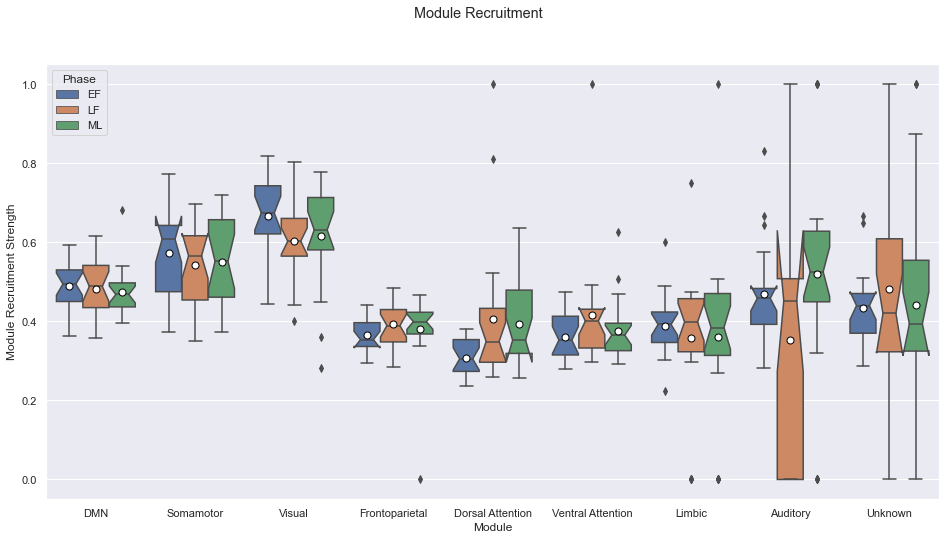

In [6]:
phase_map = {0: 'EF', 1: 'LF', 2: 'ML'}
data = {'Module': [], 'Cycle': [], 'Phase': [], 'Module Recruitment Strength': []}
for c in tqdm(range(30)):
    if c in ov_func.REMOVE:
        continue
    cycle_partitions = get_cycle_partitions(c)
    for phase_i, pt in enumerate(cycle_partitions):
        for icn in range(9):
            data['Module'].append(ov_func.AVG_EF_FN_AUDITORY[icn])
            data['Cycle'].append(c)
            data['Phase'].append(phase_map[phase_i])
            data['Module Recruitment Strength'].append(bnet.average_recruitment(pt, P[phase_map[phase_i]], icn))

plot_data = pd.DataFrame(data)
sns.set(rc={'figure.figsize':(16,8)})
bplot = sns.boxplot(data=plot_data, x="Module", y=f"Module Recruitment Strength", hue="Phase",
                    notch=True, showcaps=True, showmeans=True,
                    meanprops={"marker":"o",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                      "markersize":"7"})
fig = bplot.get_figure()
fig.suptitle("Module Recruitment")
# fig.savefig(FIG_PATH+f"network diagnosis/Module Recruitment Strength 20.png", dpi=300, bbox_inches='tight')
plt.show()

Compute the Statistical significance for each functional network's within module intergration strength

In [8]:
for icn in range(9):
    print(ov_func.AVG_EF_FN_AUDITORY[icn])
    module_data = plot_data[plot_data['Module'] == ov_func.AVG_EF_FN_AUDITORY[icn]]
    ef_c = module_data[module_data['Phase']=='EF']['Module Recruitment Strength']
    lf_c = module_data[module_data['Phase']=='LF']['Module Recruitment Strength']
    ml_c = module_data[module_data['Phase']=='ML']['Module Recruitment Strength']
    # sns.displot(module_data, x=f'{connectivity_type} Connectivity Strength (+)', hue='Phase', binwidth=0.02)
    # plt.title(ov_func.AVG_EF_FN_AUDITORY[m])
    ov_func.stat_test(ef_c, lf_c, ml_c, 1, phase_bonferroni=9*3)

DMN
	EF - LF:  88.0 14.738639831542969
	LF - ML:  98.0 21.93358612060547
	EF - ML:  78.0 8.909534454345703
Somamotor
	EF - LF:  67.0 4.453840255737305
	LF - ML:  89.0 15.406110763549805
	EF - ML:  78.0 8.909534454345703
Visual
	EF - LF:  49.0 0.9783153533935547
	LF - ML:  95.0 19.66966438293457
	EF - ML:  35.0 0.19698143005371094
Frontoparietal
	EF - LF:  47.0 0.7985343933105469
	LF - ML:  99.0 22.702199935913086
	EF - ML:  52.0 1.3079051971435547
Dorsal Attention
	EF - LF:  35.0 0.19698143005371094
	LF - ML:  81.0 10.48615837097168
	EF - ML:  12.0 0.003604888916015625
Ventral Attention
	EF - LF:  38.0 0.28859710693359375
	LF - ML:  56.0 1.878662109375
	EF - ML:  96.0 20.416494369506836
Limbic
	EF - LF:  89.0 15.406110763549805
	LF - ML:  89.0 21.84850716281391
	EF - ML:  97.0 21.171409606933594
Auditory
	EF - LF:  76.0 7.944814682006836
	LF - ML:  41.0 1.4201005086053322
	EF - ML:  58.0 2.228851318359375
Unknown
	EF - LF:  80.0 9.94346809387207
	LF - ML:  81.0 15.475562288918958
	EF -

/Users/shine/Documents/MSc/Neuro Research/Ctrb Computation/venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


## Between Module Integration Strength:

For specific pair of FN, show boxplot of the module integration change over phases. Also apply stat. test to see p-value.

In [4]:
phase_map = {0: 'EF', 1: 'LF', 2: 'ML'}

data = {'Modules': [], 'Cycle': [], 'Phase': [], f'Integration Strength': []}
integration_labels = [(0,4), (0,5), (0,3), (0,6), (4,5), (3,5), (4,3), (5,6)]
for icn1, icn2 in integration_labels:
    if icn1 == icn2:
        continue
    modules = f"{ov_func.AVG_EF_FN_ACRYNOMS[icn1]} - {ov_func.AVG_EF_FN_ACRYNOMS[icn2]}"
    for c in tqdm(range(30)):
        if c in ov_func.REMOVE:
            continue
        cycle_partitions = get_cycle_partitions(c)
        for phase_i, pt in enumerate(cycle_partitions):
            data['Modules'].append(modules)
            data['Cycle'].append(c)
            data['Phase'].append(phase_map[phase_i])
            data['Integration Strength'].append(bnet.interaction_strength(pt, P[phase_map[phase_i]], icn1, icn2))
plot_data = pd.DataFrame(data)

100%|██████████| 30/30 [00:00<00:00, 1883.47it/s]


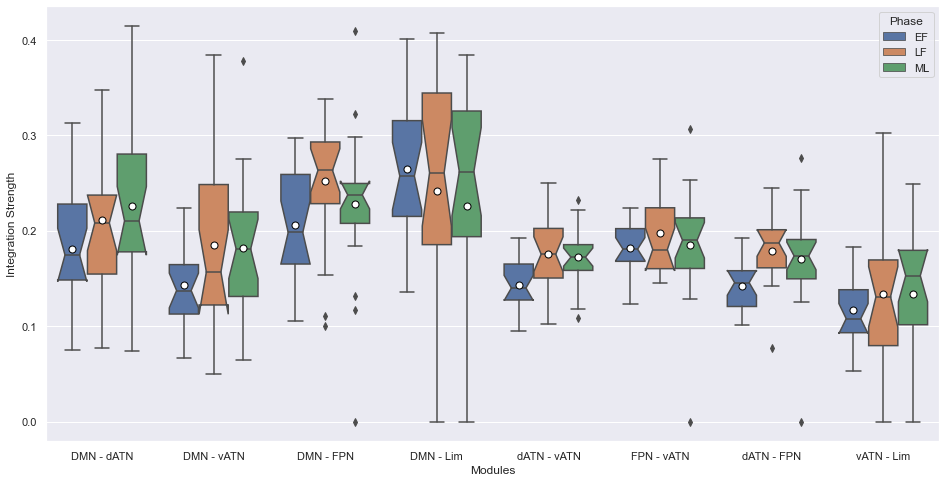

In [5]:
sns.set(rc={'figure.figsize':(16,8)})
bplot = sns.boxplot(data=plot_data, x="Modules", y=f"Integration Strength", hue="Phase",
                    notch=True, showcaps=True, showmeans=True,
                    meanprops={"marker":"o",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                      "markersize":"7"})
fig = bplot.get_figure()
# fig.savefig(FIG_PATH+"network diagnosis/Module Integration 20.png", dpi=300, bbox_inches='tight')

In [6]:
for icn1, icn2 in integration_labels:
    if icn1 == icn2:
        continue
    modules = f"{ov_func.AVG_EF_FN_ACRYNOMS[icn1]} - {ov_func.AVG_EF_FN_ACRYNOMS[icn2]}"
    print(modules)
    module_data = plot_data[plot_data['Modules'] == modules]
    ef_c = module_data[module_data['Phase']=='EF']['Integration Strength']
    lf_c = module_data[module_data['Phase']=='LF']['Integration Strength']
    ml_c = module_data[module_data['Phase']=='ML']['Integration Strength']
    # sns.displot(module_data, x=f'{connectivity_type} Connectivity Strength (+)', hue='Phase', binwidth=0.02)
    # plt.title(ov_func.AVG_EF_FN_AUDITORY[m])
    ov_func.stat_test(ef_c, lf_c, ml_c, 1, 3*8)



DMN - dATN
	EF - LF:  60.0 2.3353729248046875
	LF - ML:  85.0 11.397720336914062
	EF - ML:  30.0 0.08770751953125
DMN - vATN
	EF - LF:  35.0 0.1750946044921875
	LF - ML:  102.0 22.254684448242188
	EF - ML:  41.0 0.36749267578125
DMN - FPN
	EF - LF:  18.0 0.0115814208984375
	LF - ML:  49.0 0.8696136474609375
	EF - ML:  54.0 1.398193359375
DMN - Lim
	EF - LF:  97.0 18.81903076171875
	LF - ML:  93.0 22.460448765149234
	EF - ML:  98.0 19.49652099609375
dATN - vATN
	EF - LF:  12.0 0.003204345703125
	LF - ML:  105.0 24.0
	EF - ML:  11.0 0.0025177001953125
FPN - vATN
	EF - LF:  58.0 1.981201171875
	LF - ML:  91.0 14.91632080078125
	EF - ML:  72.0 5.5323028564453125
dATN - FPN
	EF - LF:  11.0 0.0025177001953125
	LF - ML:  95.0 17.484146118164062
	EF - ML:  41.0 0.36749267578125
vATN - Lim
	EF - LF:  68.0 4.244476318359375
	LF - ML:  76.0 10.668213663249496
	EF - ML:  76.0 7.0620574951171875


/Users/shine/Documents/MSc/Neuro Research/Ctrb Computation/venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
